In [209]:
import import_ipynb
import utils
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split


In [210]:
# préparation des données pour l'entrainement de 1992 - 2020
data_pop = utils.generate_df_from_files("./data_cleaned/population", "_population")
data_fertility = utils.generate_df_from_files("./data_cleaned/fertility", "_fertility")
data_child = utils.generate_df_from_files("./data_cleaned/child_mortality", "_child_mortality")
data_capita = utils.generate_df_from_files("./data_cleaned/gdp_capita", "_gdp_capita")
data_climat = utils.generate_df_from_files("./", "climate_cleaned")

data_climat = np.array(data_climat)
data_climat = pd.DataFrame(data_climat.squeeze())
X_list = []

for annee in range(11, 19):
        
    data_pop_slice = data_pop[annee].iloc[:, :]
    data_fertility_slice = data_fertility[annee].iloc[:, 1:]
    data_child_slice = data_child[annee].iloc[:, 1:]
    data_capita_slice = data_capita[annee].iloc[:, 1:]
    data_climat_slice = data_climat.iloc[:, 1:]
    
    concatenated_data = np.concatenate((
        data_pop_slice, 
        data_fertility_slice, 
        data_child_slice, 
        data_capita_slice,
        data_climat_slice
    ), axis=1)

    X_list.append(concatenated_data)

X = np.vstack(X_list)

In [211]:
#preparation des labels pour classification 1992-->2020 labels à 2 classes
import pandas as pd

label_class_2 = pd.read_csv("labels_class_2_class.csv")
label_class_2.head()

labels_list = []
for i in range(len(label_class_2)):
    label = label_class_2.iloc[i, :-1]
    labels_list.append(label)

y_class_2 = pd.concat(labels_list, axis=0, ignore_index=True)

In [212]:
# création des label pour tous les événements 1992->2020
import pandas as pd
df_delegations = pd.read_csv("./second_part_countries_cleaned_normalized.csv")

labels_list = []
for i in range(len(df_delegations)):
    label = df_delegations.iloc[i, :-1]
    labels_list.append(label)

y = pd.concat(labels_list, axis=0, ignore_index=True)


In [213]:
#récupération des pays
country_names = X[:, 0]
X = X[:, 1:]
# conversion des données en float32
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
y_class = np.array(y_class_2, dtype=np.float32) # choisir 2 ou 3 classes
# séparation des données en train et test
X_train, X_test, y_train, y_test, country_train, country_test, cl_train, cl_test = train_test_split(
    X, y, country_names, y_class,  test_size=0.2, random_state=42)



In [214]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import MeanSquaredError as MSE, Accuracy
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
n_folds = 3

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

regression_loss_per_fold = []
classification_loss_per_fold = []
regression_mse_per_fold = []
classification_accuracy_per_fold = []

class_weights = compute_class_weight('balanced', classes=np.unique(cl_train), y=cl_train)
class_weight_array = np.array(class_weights)


for train_index, val_index in kf.split(X_train):
    
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    cl_train_fold, cl_val_fold = cl_train[train_index], cl_train[val_index]
    
    sample_weights = np.array([class_weight_array[int(label)] for label in cl_train_fold])

    inputs = Input(shape=(X_train.shape[1],))
    x1 = Dense(150, activation='relu')(inputs)
    x2_reg = Dropout(0.3)(x1)

    x2_reg = Dense(80, activation='relu', kernel_regularizer=l2(0.01))(x2_reg)
    x2_reg = Dropout(0.3)(x2_reg)
    
    x2_reg = Dense(50, activation='relu', kernel_regularizer=l2(0.01))(x2_reg)
    x2_reg = Dropout(0.3)(x2_reg)
    
    x2_reg = Dense(50, activation='relu', kernel_regularizer=l2(0.01))(x2_reg)
    x2_reg = Dropout(0.3)(x2_reg)
    
    x2_reg = Dense(50, activation='relu', kernel_regularizer=l2(0.01))(x2_reg)
    
    output_reg = Dense(1, activation=None, name='regression_output')(x2_reg)
    output_clf = Dense(1, activation='sigmoid', name='classification_output')(x1)

    model = Model(inputs=inputs, outputs=[output_reg, output_clf])
    model.compile(
        optimizer=Adam(),
        loss={'regression_output': MeanSquaredError(), 'classification_output': BinaryCrossentropy()},
            loss_weights={
        'regression_output': 2,
        'classification_output': 0.75
    },
        metrics={'regression_output': 'mse', 'classification_output': [BinaryAccuracy(threshold=0.5)]}
    )

    history = model.fit(
        X_train_fold, 
        {'regression_output': y_train_fold, 'classification_output': cl_train_fold}, 
        epochs=60,
        batch_size=24, 
        validation_data=(X_val_fold, {'regression_output': y_val_fold, 'classification_output': cl_val_fold}),
            sample_weight=sample_weights,
        verbose=1
    )

    regression_loss_per_fold.append(history.history['regression_output_loss'])
    classification_loss_per_fold.append(history.history['classification_output_loss'])
    regression_mse_per_fold.append(history.history['regression_output_mse'])
    classification_accuracy_per_fold.append(history.history['classification_output_binary_accuracy'])
    
model.summary()


Epoch 1/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - classification_output_binary_accuracy: 0.9192 - classification_output_loss: 0.1988 - loss: 3.4077 - regression_output_loss: 0.7029 - regression_output_mse: 0.0685 - val_classification_output_binary_accuracy: 0.9180 - val_classification_output_loss: 0.2110 - val_loss: 2.7558 - val_regression_output_loss: 0.4299 - val_regression_output_mse: 0.1429
Epoch 2/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - classification_output_binary_accuracy: 0.8997 - classification_output_loss: 0.1454 - loss: 2.6913 - regression_output_loss: 0.5278 - regression_output_mse: 0.1595 - val_classification_output_binary_accuracy: 0.9180 - val_classification_output_loss: 0.1547 - val_loss: 2.1088 - val_regression_output_loss: 0.2098 - val_regression_output_mse: 0.0300
Epoch 3/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - classification_output_binary_accuracy: 0.9107 - classification_output_loss: 0.1388 - loss: 2.3003 - regression_output_loss: 0.4849 - regression_out

Model: "functional_111"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_111     │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_550 (Dense)   │ (None, 150)       │      1,350 │ input_layer_111[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_439         │ (None, 150)       │          0 │ dense_550[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_551 (Dense)   │ (None, 80)        │     12,080 │ dropout_439[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_440         │ (None, 80)        │          0 │ dense_551[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_552 (Dense)   │ (None, 50)        │      4,050 │ dropout_440[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_441         │ (None, 50)        │          0 │ dense_552[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_553 (Dense)   │ (None, 50)        │      2,550 │ dropout_441[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_442         │ (None, 50)        │          0 │ dense_553[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_554 (Dense)   │ (None, 50)        │      2,550 │ dropout_442[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output   │ (None, 1)         │         51 │ dense_554[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 1)         │        151 │ dense_550[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 68,348 (266.99 KB)

 Trainable params: 22,782 (88.99 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,566 (178.00 KB)

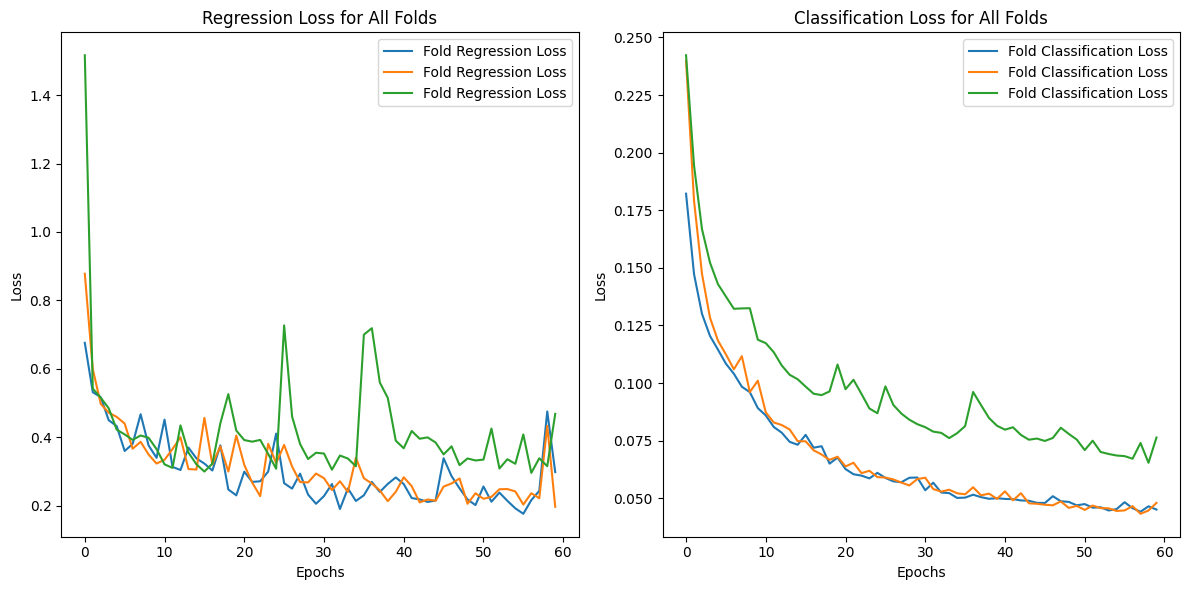

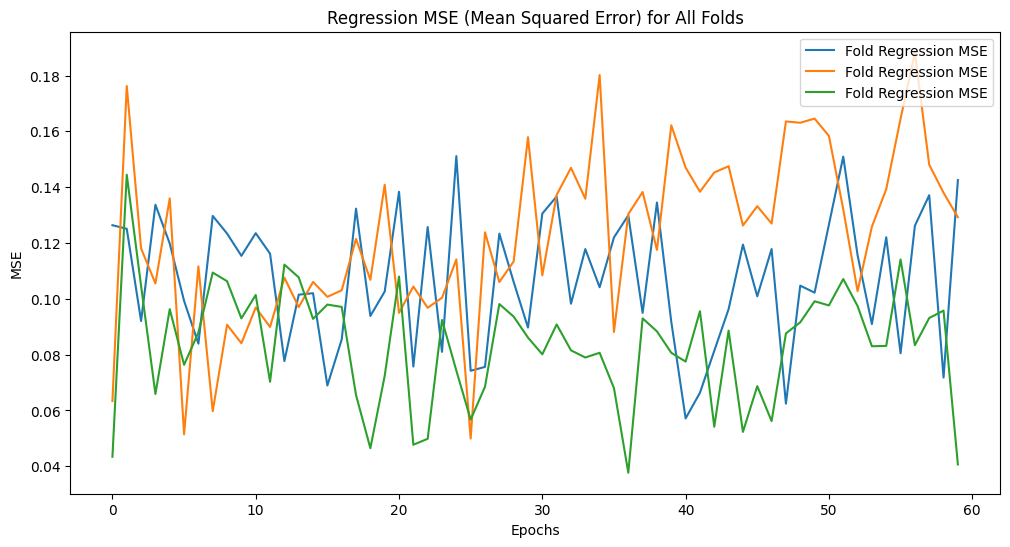

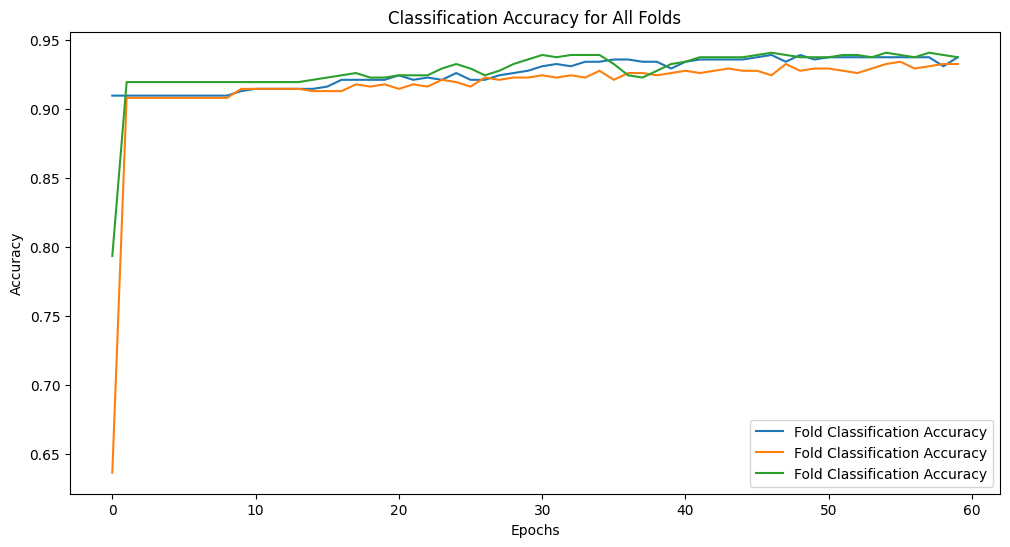

Average Validation Loss across 3 folds: 0.22263372937838236


In [215]:

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for loss in regression_loss_per_fold:
    plt.plot(loss, label='Fold Regression Loss')
plt.title('Regression Loss for All Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for loss in classification_loss_per_fold:
    plt.plot(loss, label='Fold Classification Loss')
plt.title('Classification Loss for All Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for mse in regression_mse_per_fold:
    plt.plot(mse, label='Fold Regression MSE')
plt.title('Regression MSE (Mean Squared Error) for All Folds')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()
#
plt.figure(figsize=(12, 6))
for acc in classification_accuracy_per_fold:
    plt.plot(acc, label='Fold Classification Accuracy')
plt.title('Classification Accuracy for All Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

avg_val_loss = np.mean([np.min(loss) for loss in regression_loss_per_fold])
#avg_val_accuracy = np.mean([np.max(acc) for acc in classification_accuracy_per_fold])

print(f'Average Validation Loss across {n_folds} folds: {avg_val_loss}')
#print(f'Average Validation Accuracy across {n_folds} folds: {avg_val_accuracy}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Coefficient de détermination R^2 pour la régression : -0.69


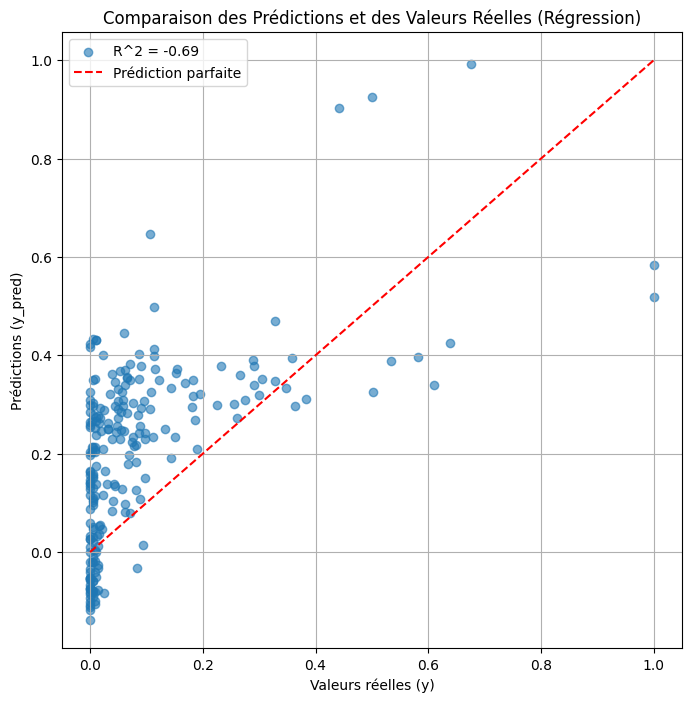

In [216]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Effectuer les prédictions sur l'ensemble de test
pred = model.predict(X_test)

# Calculer le R^2 pour la régression
r2 = r2_score(y_test, pred[0])
print(f"Coefficient de détermination R^2 pour la régression : {r2:.2f}")

# Création du graphique pour la régression
plt.figure(figsize=(8, 8))
plt.scatter(y_test, pred[0], alpha=0.6, label=f"R^2 = {r2:.2f}")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Prédiction parfaite")
plt.xlabel("Valeurs réelles (y)")
plt.ylabel("Prédictions (y_pred)")
plt.title("Comparaison des Prédictions et des Valeurs Réelles (Régression)")
plt.legend()
plt.grid(True)
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean F1 Score across all folds: 0.9085
Mean Accuracy Score across all folds: 0.9301
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


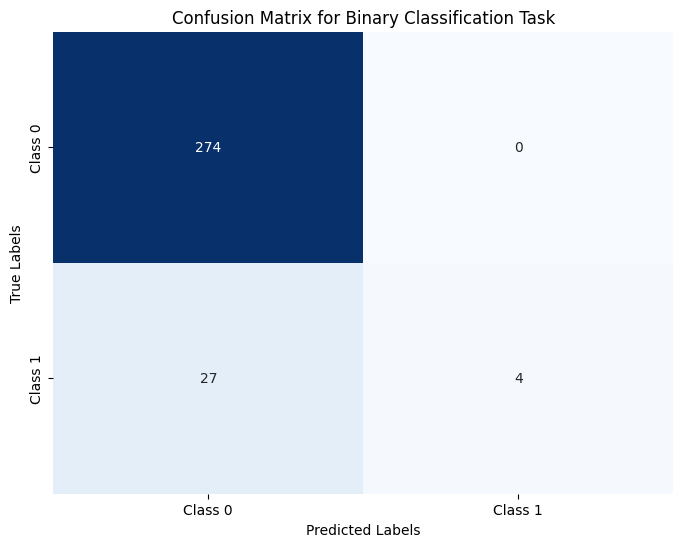

In [217]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Lists to store F1 and accuracy scores for each fold
f1_scores_per_fold = []
accuracy_scores_per_fold = []

# Loop through each fold to evaluate metrics
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    cl_train_fold, cl_val_fold = cl_train[train_index], cl_train[val_index]

    # Make predictions for the classification model on the validation set
    y_pred = model.predict(X_val_fold)  # Predicting both regression and classification outputs
    y_pred_class = (y_pred[1] > 0.5).astype(int).flatten()  # Classification output (sigmoid thresholded at 0.5)

    # Calculate F1 score and accuracy for the current fold
    f1 = f1_score(cl_val_fold, y_pred_class, average='weighted')  # Weighted F1 for binary or multi-class
    accuracy = accuracy_score(cl_val_fold, y_pred_class)

    # Append scores to the lists
    f1_scores_per_fold.append(f1)
    accuracy_scores_per_fold.append(accuracy)

# Calculate the mean F1 score and accuracy score across all folds
mean_f1_score = np.mean(f1_scores_per_fold)
mean_accuracy_score = np.mean(accuracy_scores_per_fold)

# Print the mean scores
print(f'Mean F1 Score across all folds: {mean_f1_score:.4f}')
print(f'Mean Accuracy Score across all folds: {mean_accuracy_score:.4f}')

# Compute confusion matrix for the final fold (last validation set)
y_pred = model.predict(X_val_fold)
y_pred_class = (y_pred[1] > 0.5).astype(int).flatten()  # Classification output

# Compute the confusion matrix
cm = confusion_matrix(cl_val_fold, y_pred_class)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=['Class 0', 'Class 1'],
    yticklabels=['Class 0', 'Class 1']
)
plt.title('Confusion Matrix for Binary Classification Task')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()